In this notebook we are visualizing the error of the best performing model trained in `03. Selecting best PCA value` notebook to verify if it actually fits the tumour time profiles as expected.

In [7]:
# load test dataset
import numpy as np

input_and_output = np.load("../final/dataset.npz")
inputs  = input_and_output["inputs"].astype(np.float64)
outputs = input_and_output["outputs"].astype(np.float64)

dataset_size = inputs.shape[0]
train_size = int(dataset_size * 0.7)
test_size = int(dataset_size * 0.15)
validate_size = int(dataset_size * 0.15)

inputs_validate = inputs[(train_size+test_size):(train_size+test_size+validate_size), :]
outputs_validate = outputs[(train_size+test_size):(train_size+test_size+validate_size), :]

print(f"test sizes: {inputs_validate.shape}, {outputs_validate.shape}")

test sizes: (150000, 11), (150000, 200)


In [8]:
# scaler class

from sklearn.preprocessing import MinMaxScaler
import pickle
from pathlib import Path


LOGNORMAL_PARAMETERS = (1, 2)
class CustomScaler:
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.plot_loval = [0.0] * len(LOGNORMAL_PARAMETERS)
        self.plot_hival = [1.0] * len(LOGNORMAL_PARAMETERS)

    def transform(self, x: np.ndarray, copy=None) -> np.ndarray:
        res = self.scaler.transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = (x[:, parameter_index] - self.plot_loval[i]) / (self.plot_hival[i] - self.plot_loval[i])

        return res

    def fit(self, x, copy=None):
        self.scaler.fit(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            column_values = x[:, parameter_index]

            quantile_1, quantile_3 = np.quantile(column_values, [0.25, 0.75], axis=0)
            iqr = quantile_3 - quantile_1

            loval = quantile_1 - 1.5 * iqr
            hival = quantile_3 + 1.5 * iqr

            wiskhi = np.compress(column_values <= hival, column_values)
            wisklo = np.compress(column_values >= loval, column_values)
            actual_hival = np.max(wiskhi)
            actual_loval = np.min(wisklo)

            self.plot_loval[i] = actual_loval
            self.plot_hival[i] = actual_hival

        return self

    def inverse_transform(self, x, copy=None):
        res = self.scaler.inverse_transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = x[:, parameter_index] * (self.plot_hival[i] - self.plot_loval[i]) + self.plot_loval[i]
        return res


In [13]:
# load model

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from threadpoolctl import threadpool_limits
from cpuinfo import get_cpu_info
from sklearn.decomposition import PCA


with Path(f"../final/scaler.pickle").open("rb") as scaler_file:
    scaler = pickle.load(scaler_file)

with Path(f"../final/pca/11_-7.pickle").open("rb") as opened_file:
    pca = pickle.load(opened_file)

with Path("../final/pca_models/MLPRegressor_600_100_40_11_-7_6.pickle").open("rb") as opened_file:
    regressor = pickle.load(opened_file)
    
def drop_treatment(input_data: np.ndarray) -> np.ndarray:
    """Drops treatment data from the dataset"""
    if input_data.shape[1] == 11:
        return input_data[:, 1:]

    return input_data

def predict(*args):
    with threadpool_limits(limits=get_cpu_info()["count"], user_api='blas'):
        return regressor.predict(*args)

def output_untransform(transformed_outputs: np.array) -> np.array:
    lower_limits = transformed_outputs <= -7
    z = 10 ** transformed_outputs
    z[lower_limits] = 0
    return z

model = make_pipeline(
    FunctionTransformer(drop_treatment),
    scaler,
    FunctionTransformer(predict),
    FunctionTransformer(pca.inverse_transform),
    FunctionTransformer(output_untransform)
)

calculated (150000, 11) in 9.20062780380249


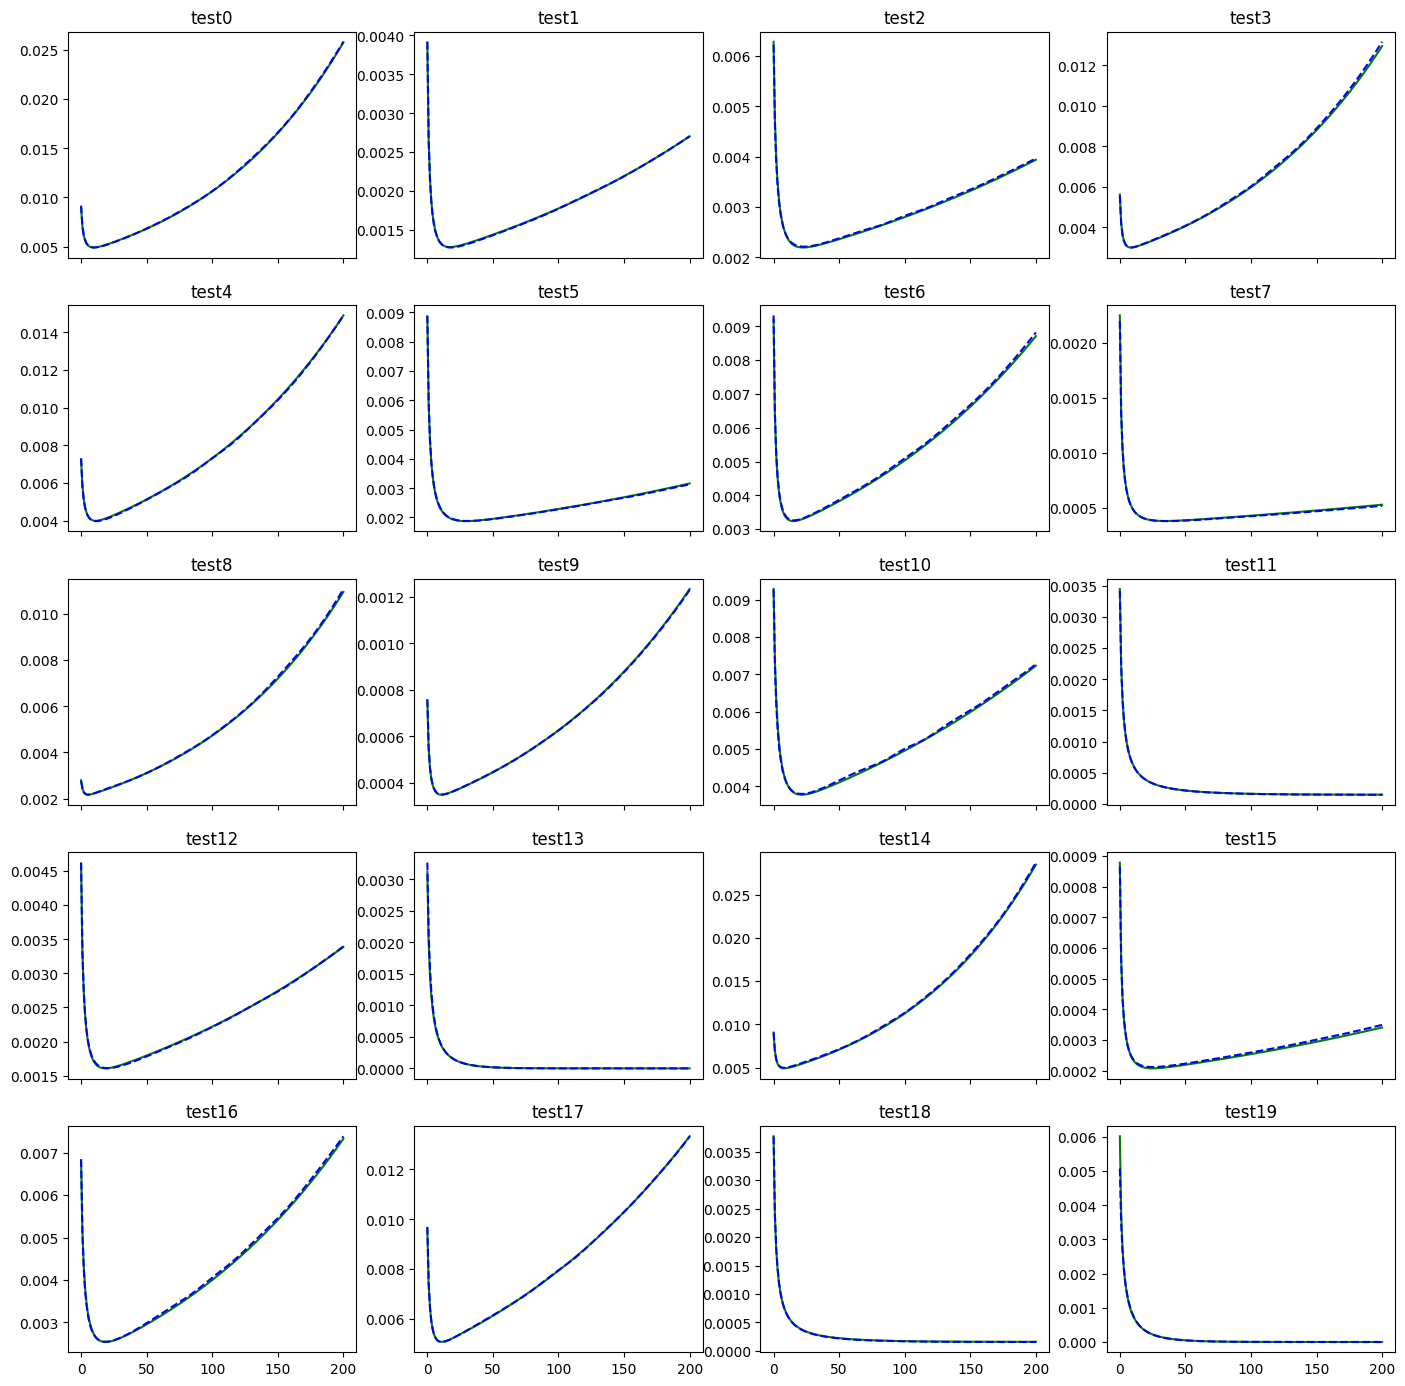

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

sample_size = 20
x_axis = np.linspace(0, 200, outputs_validate.shape[1])

rows, cols = (sample_size + 3) // 4, 4
figure, axs = plt.subplots(rows, cols, sharex=True)
figure.set_size_inches(cols * 3.5, rows * 3)
figure.tight_layout(h_pad=2.4, rect=(0, 0, 1, 1.0 - 0.4 / rows))

import time 
start_time = time.time()
predictions = model.transform(inputs_validate)
print(f"calculated {inputs_validate.shape} in {time.time() - start_time}")

for row in range(rows):
    for col in range(cols):
        i = row * cols + col
        if i < sample_size:
            axs[row, col].set_title(f"test{i}")
            axs[row, col].plot(x_axis, outputs_validate[i, :], color='green')
            axs[row, col].plot(x_axis, predictions[i, :], color='blue', linestyle='dashed')

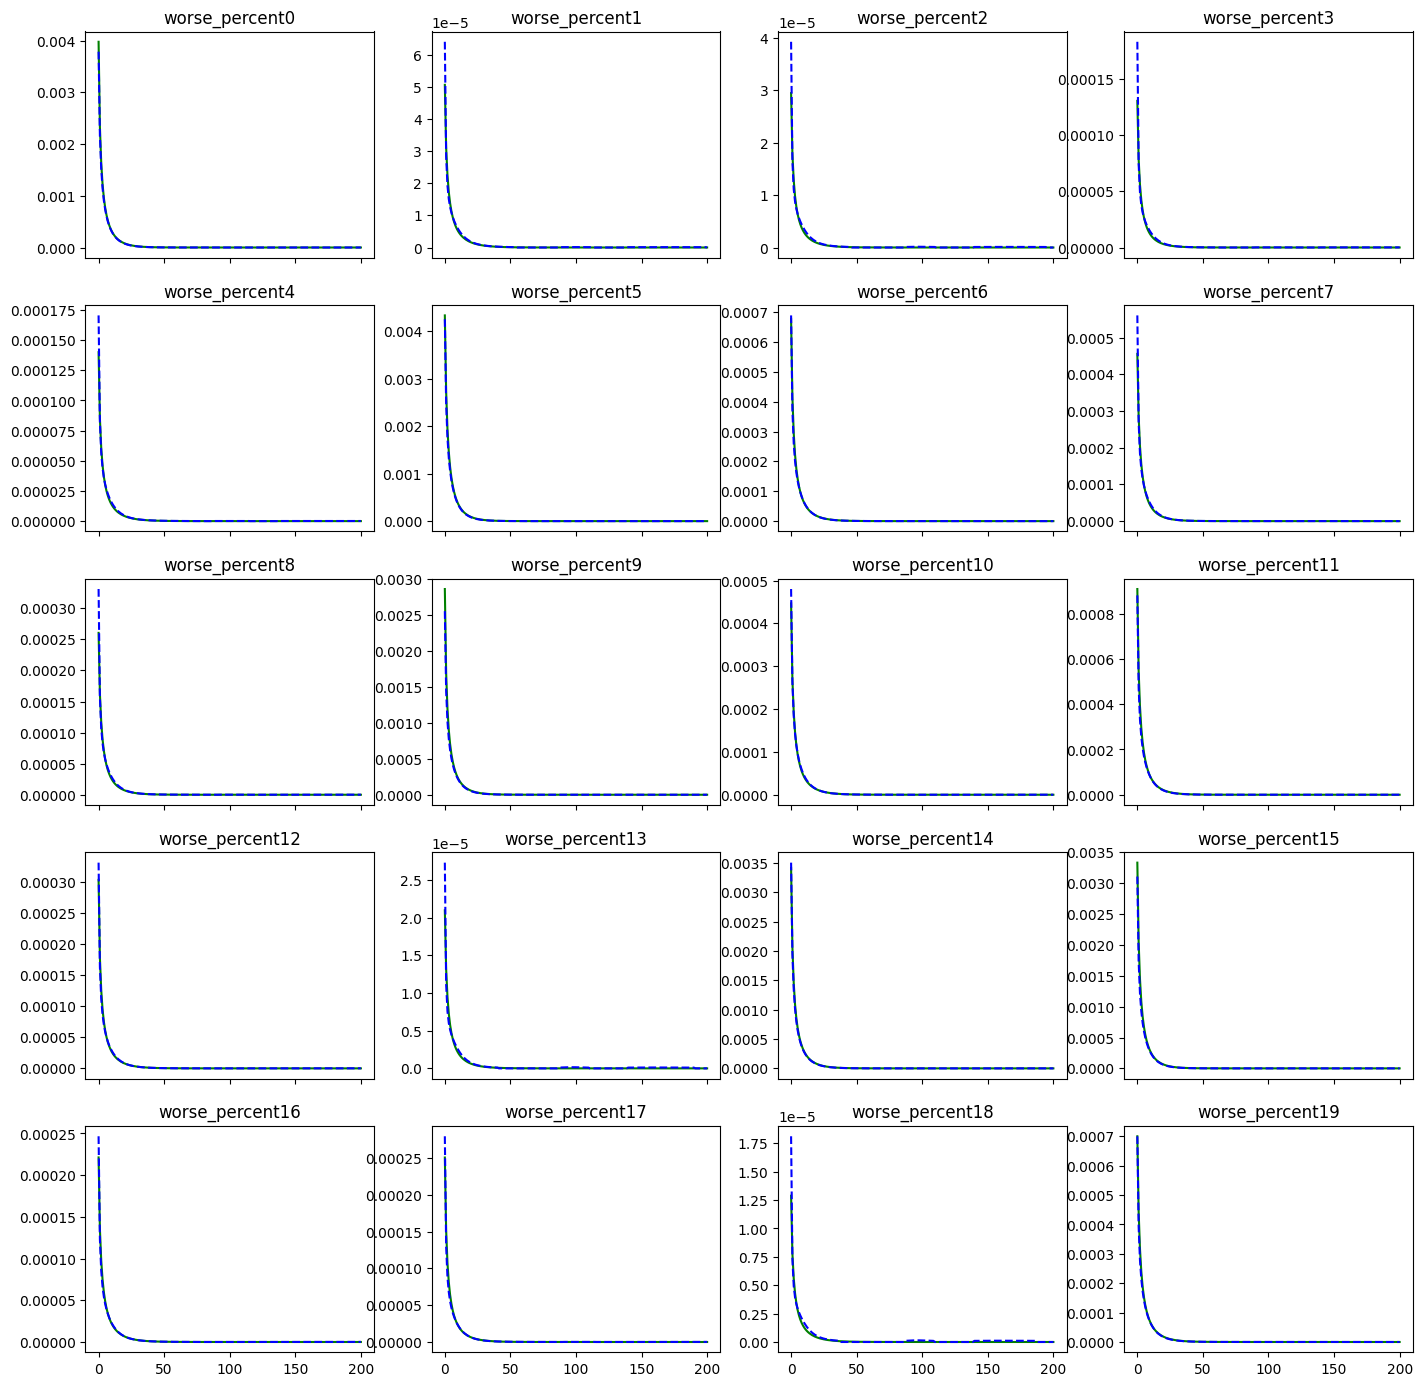

In [15]:
import matplotlib.pyplot as plt

figure, axs = plt.subplots(rows, cols, sharex=True)
figure.set_size_inches(cols * 3.5, rows * 3)
figure.tight_layout(h_pad=2.4, rect=(0, 0, 1, 1.0 - 0.4 / rows))

a = np.amax(np.divide(np.absolute(outputs_validate - predictions), outputs_validate), axis=1)
ind = np.argpartition(a, -sample_size)[-sample_size:]

for row in range(rows):
    for col in range(cols):
        i = row * cols + col
        if i < sample_size:
            axs[row, col].set_title(f"worse_percent{i}")
            axs[row, col].plot(x_axis, outputs_validate[ind[i], :], color='green') 
            axs[row, col].plot(x_axis, predictions[ind[i], :], color='blue', linestyle='dashed')

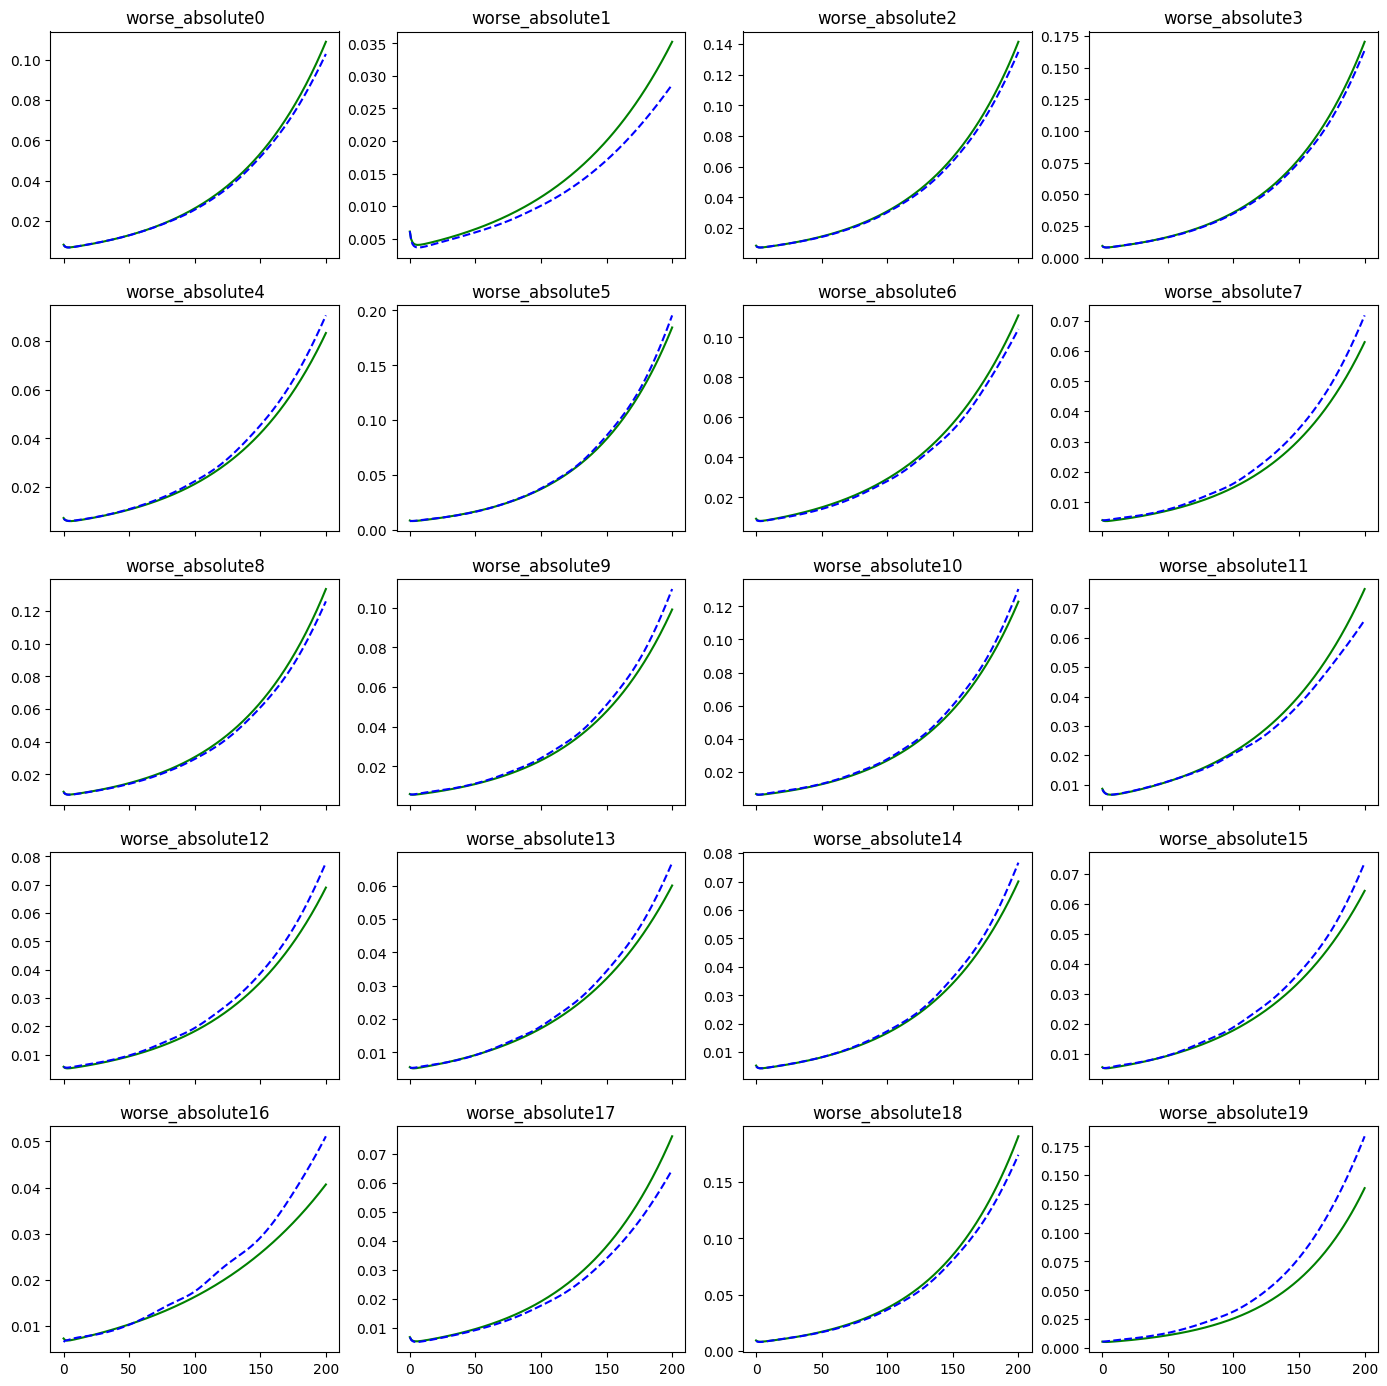

In [16]:
import matplotlib.pyplot as plt

figure, axs = plt.subplots(rows, cols, sharex=True)
figure.set_size_inches(cols * 3.5, rows * 3)
figure.tight_layout(h_pad=2.4, rect=(0, 0, 1, 1.0 - 0.4 / rows))

a = np.amax(np.absolute(outputs_validate - predictions), axis=1)
ind = np.argpartition(a, -sample_size)[-sample_size:]

for row in range(rows):
    for col in range(cols):
        i = row * cols + col
        if i < sample_size:
            axs[row, col].set_title(f"worse_absolute{i}")
            axs[row, col].plot(x_axis, outputs_validate[ind[i], :], color='green') 
            axs[row, col].plot(x_axis, predictions[ind[i], :], color='blue', linestyle='dashed')